# Text Generator
This project implements a LSTM Deep Neural Network that is able to predict the next character of a string. By repeating this process multiple times the model can generate a sequence of text.

First, we start by importing:

In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
import matplotlib.pyplot as plt

## Data Loading

Then, we load the database. In this case, I decided to use an three novels uploaded as .txt files available in https://www.gutenberg.org/. This is because these novels are no longer protected by copyright and are easily obtainable.
I choose the following novels: 
* [The Adventures of Sherlock Holmes, by Arthur Conan Doyle](https://www.gutenberg.org/ebooks/1661)
* [Pride and Prejudice by Jane Austen](https://www.gutenberg.org/ebooks/1342)
* [Moby Dick; Or, The Whale by Herman Melville](https://www.gutenberg.org/ebooks/2701)


In [75]:
sherlock_to_file = tf.keras.utils.get_file('1661-0.txt',
                                       'https://www.gutenberg.org/files/1661/1661-0.txt')
sherlock_raw_text = open(sherlock_to_file, 'rb').read().decode(encoding='utf-8')

In [76]:
sherlock_raw_text = sherlock_raw_text[sherlock_raw_text.find("I. A SCANDAL IN BOHEMIA") : sherlock_raw_text.find("End of the Project Gutenberg EBook of The Adventures of Sherlock Holmes")]

print("Beginning:")
print(sherlock_raw_text[:100])
print("[...]\n\nEnding:\n[...]")
print(sherlock_raw_text[-100:])

Beginning:
I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard
[...]

Ending:
[...]
rivate school at
Walsall, where I believe that she has met with considerable success.









In [86]:
pride_to_file = tf.keras.utils.get_file('1342-0.txt',
                                       'https://www.gutenberg.org/files/1342/1342-0.txt')
pride_raw_text = open(pride_to_file, 'rb').read().decode(encoding='utf-8')

In [88]:
pride_raw_text = pride_raw_text[pride_raw_text.find("      Chapter 1\r\n\r\n      ") : pride_raw_text.find("End of the Project Gutenberg EBook of Pride and Prejudice, by Jane Austen")]

print("Beginning:")
print(pride_raw_text[:100])
print("[...]\n\nEnding:\n[...]")
print(pride_raw_text[-100:])

Beginning:
      Chapter 1

      It is a truth universally acknowledged, that a single man in
      possess
[...]

Ending:
[...]
   who, by bringing her into Derbyshire, had been the means of
      uniting them.
    


    


In [96]:
moby_to_file = tf.keras.utils.get_file('2701-0.txt',
                                       'https://www.gutenberg.org/files/2701/2701-0.txt')
moby_raw_text = open(moby_to_file, 'rb').read().decode(encoding='utf-8')

In [97]:
moby_raw_text = moby_raw_text[moby_raw_text.find("\r\n\r\nEpilogue\r\n") : moby_raw_text.find("End of the Project Gutenberg EBook of Pride and Prejudice, by Jane Austen")]

print("Beginning:")
print(moby_raw_text[:100])
print("[...]\n\nEnding:\n[...]")
print(moby_raw_text[-100:])

Beginning:


Epilogue




Original Transcriber’s Notes:





This text is a combination of etexts,
[...]

Ending:
[...]
our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.








In [98]:
raw_text = sherlock_raw_text + pride_raw_text + moby_raw_text  # Join the dataset
text = re.sub(r'%|@|_|£|½|à|â|æ|è|é|œ|—|\r|\t|ê|Œ|η|ο|ς|τ|ϰ|ו|ח', '', raw_text)  # Delete unwanted chars

## Data Pre-processing

In [104]:
vocabulary = sorted(set(text))
voc_size = len(vocabulary)

charToNum = {u:i for i, u in enumerate(vocabulary)}  # Dictionary that transforms chars to numbers
numToChar = np.array(vocabulary)  # List that transforms numbers to chars

print("The length of the vocabulary: ", len(vocabulary))
print(charToNum)
print(numToChar)

The length of the vocabulary:  83
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, '(': 5, ')': 6, '*': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '?': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 'J': 34, 'K': 35, 'L': 36, 'M': 37, 'N': 38, 'O': 39, 'P': 40, 'Q': 41, 'R': 42, 'S': 43, 'T': 44, 'U': 45, 'V': 46, 'W': 47, 'X': 48, 'Y': 49, 'Z': 50, '[': 51, ']': 52, 'a': 53, 'b': 54, 'c': 55, 'd': 56, 'e': 57, 'f': 58, 'g': 59, 'h': 60, 'i': 61, 'j': 62, 'k': 63, 'l': 64, 'm': 65, 'n': 66, 'o': 67, 'p': 68, 'q': 69, 'r': 70, 's': 71, 't': 72, 'u': 73, 'v': 74, 'w': 75, 'x': 76, 'y': 77, 'z': 78, '‘': 79, '’': 80, '“': 81, '”': 82}
['\n' ' ' '!' '$' '&' '(' ')' '*' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K'
 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '[' ']' 'a'
 'b' 'c

In [105]:
def textToNums(text):
  return np.array([charToNum[char] for char in text]) 

text_in_nums = textToNums(text)
text_in_nums

array([33, 10,  1, ...,  0,  0,  0])

In [106]:
dataset = tf.data.Dataset.from_tensor_slices(text_in_nums)

seq101 = dataset.batch(101, drop_remainder=True)



In [107]:
seqX = seq101.map(lambda x: x[:-1])

for item in seqX.take(2):  # Print two examples
  print(len(item.numpy()))
  print(numToChar[item.numpy()])

100
['I' '.' ' ' 'A' ' ' 'S' 'C' 'A' 'N' 'D' 'A' 'L' ' ' 'I' 'N' ' ' 'B' 'O'
 'H' 'E' 'M' 'I' 'A' '\n' '\n' '\n' 'I' '.' '\n' '\n' 'T' 'o' ' ' 'S' 'h'
 'e' 'r' 'l' 'o' 'c' 'k' ' ' 'H' 'o' 'l' 'm' 'e' 's' ' ' 's' 'h' 'e' ' '
 'i' 's' ' ' 'a' 'l' 'w' 'a' 'y' 's' ' ' 't' 'h' 'e' ' ' 'w' 'o' 'm' 'a'
 'n' '.' ' ' 'I' ' ' 'h' 'a' 'v' 'e' ' ' 's' 'e' 'l' 'd' 'o' 'm' ' ' 'h'
 'e' 'a' 'r' 'd' ' ' 'h' 'i' 'm' '\n' 'm' 'e']
100
['t' 'i' 'o' 'n' ' ' 'h' 'e' 'r' ' ' 'u' 'n' 'd' 'e' 'r' ' ' 'a' 'n' 'y'
 ' ' 'o' 't' 'h' 'e' 'r' ' ' 'n' 'a' 'm' 'e' '.' ' ' 'I' 'n' ' ' 'h' 'i'
 's' ' ' 'e' 'y' 'e' 's' ' ' 's' 'h' 'e' ' ' 'e' 'c' 'l' 'i' 'p' 's' 'e'
 's' ' ' 'a' 'n' 'd' '\n' 'p' 'r' 'e' 'd' 'o' 'm' 'i' 'n' 'a' 't' 'e' 's'
 ' ' 't' 'h' 'e' ' ' 'w' 'h' 'o' 'l' 'e' ' ' 'o' 'f' ' ' 'h' 'e' 'r' ' '
 's' 'e' 'x' '.' ' ' 'I' 't' ' ' 'w' 'a']


In [108]:
seqY = seq101.map(lambda x: x[1:])

for item in seqY.take(2):  # Print two examples
  print(len(item.numpy()))
  print(numToChar[item.numpy()])

100
['.' ' ' 'A' ' ' 'S' 'C' 'A' 'N' 'D' 'A' 'L' ' ' 'I' 'N' ' ' 'B' 'O' 'H'
 'E' 'M' 'I' 'A' '\n' '\n' '\n' 'I' '.' '\n' '\n' 'T' 'o' ' ' 'S' 'h' 'e'
 'r' 'l' 'o' 'c' 'k' ' ' 'H' 'o' 'l' 'm' 'e' 's' ' ' 's' 'h' 'e' ' ' 'i'
 's' ' ' 'a' 'l' 'w' 'a' 'y' 's' ' ' 't' 'h' 'e' ' ' 'w' 'o' 'm' 'a' 'n'
 '.' ' ' 'I' ' ' 'h' 'a' 'v' 'e' ' ' 's' 'e' 'l' 'd' 'o' 'm' ' ' 'h' 'e'
 'a' 'r' 'd' ' ' 'h' 'i' 'm' '\n' 'm' 'e' 'n']
100
['i' 'o' 'n' ' ' 'h' 'e' 'r' ' ' 'u' 'n' 'd' 'e' 'r' ' ' 'a' 'n' 'y' ' '
 'o' 't' 'h' 'e' 'r' ' ' 'n' 'a' 'm' 'e' '.' ' ' 'I' 'n' ' ' 'h' 'i' 's'
 ' ' 'e' 'y' 'e' 's' ' ' 's' 'h' 'e' ' ' 'e' 'c' 'l' 'i' 'p' 's' 'e' 's'
 ' ' 'a' 'n' 'd' '\n' 'p' 'r' 'e' 'd' 'o' 'm' 'i' 'n' 'a' 't' 'e' 's' ' '
 't' 'h' 'e' ' ' 'w' 'h' 'o' 'l' 'e' ' ' 'o' 'f' ' ' 'h' 'e' 'r' ' ' 's'
 'e' 'x' '.' ' ' 'I' 't' ' ' 'w' 'a' 's']


In [109]:
zip_dataset = tf.data.Dataset.zip((seqX, seqY))  # Zip the datasets

for input, output in zip_dataset.take(2):
  print(numToChar[input.numpy()])
  print(numToChar[output.numpy()])

['I' '.' ' ' 'A' ' ' 'S' 'C' 'A' 'N' 'D' 'A' 'L' ' ' 'I' 'N' ' ' 'B' 'O'
 'H' 'E' 'M' 'I' 'A' '\n' '\n' '\n' 'I' '.' '\n' '\n' 'T' 'o' ' ' 'S' 'h'
 'e' 'r' 'l' 'o' 'c' 'k' ' ' 'H' 'o' 'l' 'm' 'e' 's' ' ' 's' 'h' 'e' ' '
 'i' 's' ' ' 'a' 'l' 'w' 'a' 'y' 's' ' ' 't' 'h' 'e' ' ' 'w' 'o' 'm' 'a'
 'n' '.' ' ' 'I' ' ' 'h' 'a' 'v' 'e' ' ' 's' 'e' 'l' 'd' 'o' 'm' ' ' 'h'
 'e' 'a' 'r' 'd' ' ' 'h' 'i' 'm' '\n' 'm' 'e']
['.' ' ' 'A' ' ' 'S' 'C' 'A' 'N' 'D' 'A' 'L' ' ' 'I' 'N' ' ' 'B' 'O' 'H'
 'E' 'M' 'I' 'A' '\n' '\n' '\n' 'I' '.' '\n' '\n' 'T' 'o' ' ' 'S' 'h' 'e'
 'r' 'l' 'o' 'c' 'k' ' ' 'H' 'o' 'l' 'm' 'e' 's' ' ' 's' 'h' 'e' ' ' 'i'
 's' ' ' 'a' 'l' 'w' 'a' 'y' 's' ' ' 't' 'h' 'e' ' ' 'w' 'o' 'm' 'a' 'n'
 '.' ' ' 'I' ' ' 'h' 'a' 'v' 'e' ' ' 's' 'e' 'l' 'd' 'o' 'm' ' ' 'h' 'e'
 'a' 'r' 'd' ' ' 'h' 'i' 'm' '\n' 'm' 'e' 'n']
['t' 'i' 'o' 'n' ' ' 'h' 'e' 'r' ' ' 'u' 'n' 'd' 'e' 'r' ' ' 'a' 'n' 'y'
 ' ' 'o' 't' 'h' 'e' 'r' ' ' 'n' 'a' 'm' 'e' '.' ' ' 'I' 'n' ' ' 'h' 'i'
 's' ' ' 'e' 'y' 'e' 's' ' '

In [110]:
BATCH_SIZE = 64
BUFFER_SIZE = len(text_in_nums)

dataset_shuffled = zip_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)  # Organize the dataset in batches

## Define the Model

In [111]:
model = Sequential()

model.add(Embedding(voc_size, 256, batch_input_shape=[BATCH_SIZE, None], input_length=100))
model.add(LSTM(1024, return_sequences=True, stateful=True))
model.add(Dropout(0.2))
model.add(Dense(voc_size))

In [112]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (64, None, 256)           21248     
_________________________________________________________________
lstm_5 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dropout_3 (Dropout)          (64, None, 1024)          0         
_________________________________________________________________
dense_5 (Dense)              (64, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Define a checkpoint callback:

checkpoints_path = "./checkpoints"
checkpoint = ModelCheckpoint(checkpoints_path, verbose=1, save_weights_only=True)

## Train the Model

In [114]:
EPOCHS = 100
history = model.fit(dataset_shuffled, epochs=EPOCHS, callbacks=[checkpoint])

model.save_weights('./training-{}epochs'.format(EPOCHS))

Epoch 1/100
393/393 [==============================] - ETA: 0s - loss: 2.4293 - accuracy: 0.3235
Epoch 00001: saving model to ./checkpoints
393/393 [==============================] - 35s 90ms/step - loss: 2.4293 - accuracy: 0.3235
Epoch 2/100
393/393 [==============================] - ETA: 0s - loss: 1.8159 - accuracy: 0.4672
Epoch 00002: saving model to ./checkpoints
393/393 [==============================] - 35s 90ms/step - loss: 1.8159 - accuracy: 0.4672
Epoch 3/100
393/393 [==============================] - ETA: 0s - loss: 1.6031 - accuracy: 0.5240
Epoch 00003: saving model to ./checkpoints
393/393 [==============================] - 36s 91ms/step - loss: 1.6031 - accuracy: 0.5240
Epoch 4/100
393/393 [==============================] - ETA: 0s - loss: 1.4951 - accuracy: 0.5527
Epoch 00004: saving model to ./checkpoints
393/393 [==============================] - 36s 92ms/step - loss: 1.4951 - accuracy: 0.5527
Epoch 5/100
393/393 [==============================] - ETA: 0s - loss: 1.428

In [67]:
!ls

checkpoint				training-100epochs.index
checkpoints.data-00000-of-00001		training-150epochs.data-00000-of-00001
checkpoints.index			training-150epochs.index
sample_data				training-200epochs.data-00000-of-00001
training-100epochs.data-00000-of-00001	training-200epochs.index



## Predictions
Now we will load the trained model to a new model with a batch size of 1. We will use this new model to make predictions.

In [125]:
predictor = Sequential()

predictor.add(Embedding(voc_size, 256, batch_input_shape=[1, None], input_length=100))
predictor.add(LSTM(1024, return_sequences=True, stateful=True))
predictor.add(Dense(voc_size))

predictor.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
predictor.summary()


predictor.load_weights('./training-{}epochs'.format(EPOCHS))

predictor.build(input_shape=([1,None]))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_7 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_7 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


A function to generate predictions with this new model.

In [51]:
def generate_text(predictor, seed, temperature = 0.50):
  input_nums = [charToNum[s] for s in seed]
  input_nums = tf.expand_dims(input_nums, 0)
  predictor.reset_states()
  

  result = []
  for i in range(500):
    prediction = predictor(input_nums)
    prediction = tf.squeeze(prediction, 0)

    prediction = prediction / temperature

    pred_num = tf.random.categorical(prediction, num_samples=1)[-1, 0].numpy()

    input_nums = tf.expand_dims([pred_num], 0)

    result.append(numToChar[pred_num])

  return seed + ''.join(result)

## Tests

In [117]:
test1 = generate_text(predictor, "For what is worth, ")
print(test1)

For what is worth, and one of the grounds of life and
milders and marble leg. And then, and for thirty years in the water there, he
seemed strangely mounting to the sea as the magnetic seas, which he had never been stepped about
to have a good conditional impertinent was a good just power, the sea bears a harpooneer in the patience of
the country. I have no doubt that is all. I have not a communication like them?”

“And have you the chance to myself,” said he, “that of all sides is in the clear midnight defection.


In [118]:
test2 = generate_text(predictor, "When about a hundred yards from the pool I heard a cry of Cooee! which was a usual ")
print(test2)

When about a hundred yards from the pool I heard a cry of Cooee! which was a usual servant among the most interesting to it. It is
a subject, that when he left the room swiftly sly, perpendicularly and unaccountable
to affair where the living harpoon may be similar to
the interview.

“As the great living flowers they were born, and in that subterraneous horrible way, as a sudden snap and
sleep in the continents of the whale, and removed the bell, and the white brow is
buttoned up to him seemed to have been considered a strange tent with a man in a supply of the
same precious f


In [124]:
test3 = generate_text(predictor, "To be honest, I ")
print(test3)

To be honest, I thought that it would be to
prevent your connection at the bank when I was the same that
had been seen steering on the ship’s room, he said, to my assure that we are all simplication, I shall
continue to be a simple case in the morning and laugh. I shall be my own
master? I will read the least into the singular scheme of the
morning of the traveller. It is the whale which may not be absolutely copied on that young
principle; though in last men are the first that the boys were left in the
steps, 


## Training Plots

As we can see in the plots below, the model reached its peak around the 60th Epoch, with a precision of 72%.

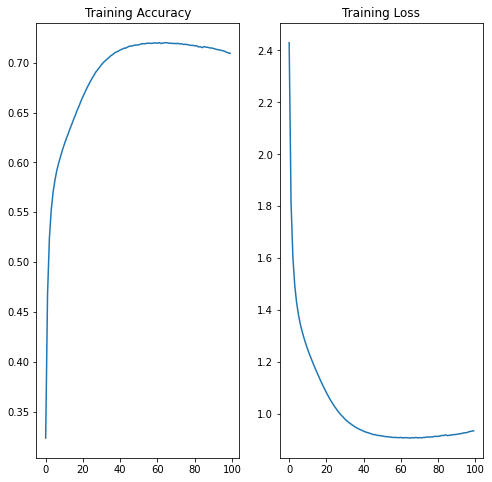

In [126]:
acc = history.history['accuracy']
loss=history.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc)
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss)
plt.title('Training Loss')
plt.show()